In [2]:
import numpy as np
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt

train_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='training',
    batch_size=8,
    shuffle=True,
    seed=123
)
test_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='validation',
    batch_size=8,
    shuffle=True,
    seed=123
)

Found 1200 files belonging to 3 classes.
Using 960 files for training.
Found 1200 files belonging to 3 classes.
Using 240 files for validation.


In [3]:
# Визначення
#    розміру словнику (vocab_size),
#    максимального розміру словнику (max_tokens)

def standardization(input_data):
    output = tf.strings.lower(input_data, encoding='utf-8')
    output = tf.strings.regex_replace(output, '[%s]' % re.escape(string.punctuation), '')
    output = tf.strings.regex_replace(output, '[%s]' % (b'\xc2\xa0'.decode() + b'\xe2\xa0\x80'.decode()), ' ')
    return output

def analyse_dataset(raw_ds):
    documents_ds = raw_ds.map(lambda x, y: x)
    words_ds = documents_ds.map(lambda document: tf.strings.split(standardization(document))).unbatch()
    vocab_ds = words_ds.flat_map(tf.data.Dataset.from_tensor_slices).apply(tf.data.experimental.unique())
    vocab_size = vocab_ds.reduce(0, lambda count, x: count + 1).numpy()
    return vocab_size
    
vocab_size = analyse_dataset(train_raw_ds)
max_tokens = vocab_size + 2
print('vocab_size:', vocab_size)
print('max_tokens:', max_tokens)

# Додавання шару векторизації тексту
def custom_text_vectorization_layer(raw_ds, max_tokens):
    documents_ds = raw_ds.map(lambda x, y: x)
    layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        standardize=standardization,
        max_tokens=max_tokens,
    )
    layer.adapt(documents_ds)
    return layer
    
text_vect_layer = custom_text_vectorization_layer(train_raw_ds, max_tokens)
print('effective vocabulary size:', len(text_vect_layer.get_vocabulary()))
print(f"Vocabulary: [{','.join(text_vect_layer.get_vocabulary()[50:60])}'...]")

vocab_size: 20732
max_tokens: 20734
effective vocabulary size: 20734
Vocabulary: [можете,как,можна,экран,к,5,pro,дисплей,щоб,из'...]


In [6]:
# FCNN model
fcnn = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
fcnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
fcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         2073400   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 2,094,203
Trainable params: 2,094,203
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
120/120 [==============================] - 5s 40ms/step - loss: 0.9636 - acc: 0.5667 - val_loss: 0.8796 - val_acc: 0.5542
Epoch 2/20
120/120 [==============================] - 5s 39ms/step - loss: 0.5772 - acc: 0.7792 - val_loss: 0.4323 - val_acc: 0.9000
Epoch 3/20
120/120 [==============================] - 4s 37ms/step - loss: 0.2544 - acc: 0.9531 - val_loss: 0.2364 - val_acc: 0.9417
Epoch 4/20
120/120 [==============================] - 4s 36ms/step - loss: 0.1571 - acc: 0.9604 - val_loss: 0.2128 - val_acc: 0.9375
Epoch 5/20
120/120 [==============================] - 4s 34ms/step - loss: 0.1061 - acc: 0.9708 - val_loss: 0.1720 - val_acc: 0.9417
Epoch 6/20
120/120 [==============================] - 4s 35ms/step - loss: 0.0926 - acc: 0.9729 - val_loss: 0.2101 - val_acc: 0.9375
Epoch 7/20
120/120 [==============================] - 4s 35ms/step - loss: 0.0696 - acc: 0.9823 - val_loss: 0.1336 - val_acc: 0.9625
Epoch 8/20
120/120 [==============================] - 5s 45ms/step - 

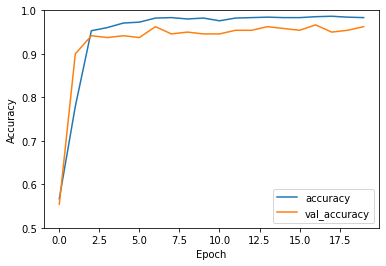

In [7]:
history = fcnn.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=20)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [125]:
# FCNN model
fcnn = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 50),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
fcnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
fcnn.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_58 (TextV (None, None)              0         
_________________________________________________________________
embedding_37 (Embedding)     (None, None, 50)          1036700   
_________________________________________________________________
global_average_pooling1d_14  (None, 50)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 303       
Total params: 1,042,103
Trainable params: 1,042,103
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
120/120 [==============================] - 4s 31ms/step - loss: 1.0191 - acc: 0.5719 - val_loss: 0.9246 - val_acc: 0.6583
Epoch 2/20
120/120 [==============================] - 3s 28ms/step - loss: 0.7112 - acc: 0.7479 - val_loss: 0.6870 - val_acc: 0.7000
Epoch 3/20
120/120 [==============================] - 4s 33ms/step - loss: 0.4418 - acc: 0.8625 - val_loss: 0.4197 - val_acc: 0.8667
Epoch 4/20
120/120 [==============================] - 4s 34ms/step - loss: 0.2599 - acc: 0.9438 - val_loss: 0.2971 - val_acc: 0.9000
Epoch 5/20
120/120 [==============================] - 4s 36ms/step - loss: 0.1725 - acc: 0.9646 - val_loss: 0.2042 - val_acc: 0.9500
Epoch 6/20
120/120 [==============================] - 4s 33ms/step - loss: 0.1437 - acc: 0.9615 - val_loss: 0.2101 - val_acc: 0.9292
Epoch 7/20
120/120 [==============================] - 4s 35ms/step - loss: 0.1039 - acc: 0.9792 - val_loss: 0.1387 - val_acc: 0.9583
Epoch 8/20
120/120 [==============================] - 4s 31ms/step - 

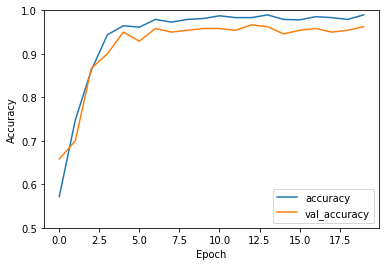

In [126]:
history = fcnn.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=20)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [129]:
# FCNN model
fcnn = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 20),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
fcnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
fcnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_60 (TextV (None, None)              0         
_________________________________________________________________
embedding_39 (Embedding)     (None, None, 20)          414680    
_________________________________________________________________
global_average_pooling1d_16  (None, 20)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 123       
Total params: 415,643
Trainable params: 415,643
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
120/120 [==============================] - 2s 19ms/step - loss: 1.0654 - acc: 0.5104 - val_loss: 1.0247 - val_acc: 0.5792
Epoch 2/20
120/120 [==============================] - 2s 14ms/step - loss: 0.8646 - acc: 0.6927 - val_loss: 0.8650 - val_acc: 0.7625
Epoch 3/20
120/120 [==============================] - 2s 15ms/step - loss: 0.6833 - acc: 0.7771 - val_loss: 0.7003 - val_acc: 0.8292
Epoch 4/20
120/120 [==============================] - 2s 15ms/step - loss: 0.4971 - acc: 0.8760 - val_loss: 0.5120 - val_acc: 0.8833
Epoch 5/20
120/120 [==============================] - 2s 15ms/step - loss: 0.3548 - acc: 0.9281 - val_loss: 0.3724 - val_acc: 0.9083
Epoch 6/20
120/120 [==============================] - 2s 15ms/step - loss: 0.2631 - acc: 0.9510 - val_loss: 0.2784 - val_acc: 0.9375
Epoch 7/20
120/120 [==============================] - 2s 15ms/step - loss: 0.2004 - acc: 0.9615 - val_loss: 0.2576 - val_acc: 0.9292
Epoch 8/20
120/120 [==============================] - 2s 15ms/step - 

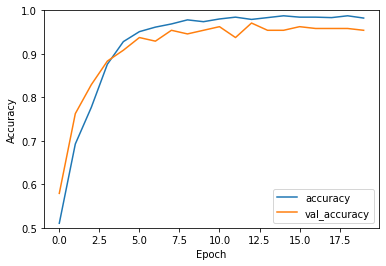

In [130]:
history = fcnn.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=20)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()